In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.patches as mpatches
import sys
sys.path.insert(1, 'code')
from help_funcs import *
import matplotlib
import scipy.io
matplotlib.rcParams.update({'font.size': 18})

REVISION_DATA_DIR ='revision_data'

## Response Fig 3A (numbering from modeling draft)

In [2]:
## Compile firing rates from sim data and save mat file

simname = 'dl'
seed = 2
seedlist = [i for i in range(1,22)]
binlen = 200
nsecs = 5
delay = 200
stimargs = {'binlen': binlen, 'delay': delay, 'n_repeats' : 6}

all_spont_E, all_spont_P, all_spont_S = [], [], []

for del_range in [0.0, 0.3, 1.0]:
    
    spont_E, spont_P, spont_S = [], [], []

    for seed in seedlist:

        folder = 'data/%s_%s/results_%s/'%(simname, del_range, seed)


        try:
            with open(folder + 'Spont_spikes.pickle', 'rb') as f:
                all_spikes = pickle.load(f)
            with open(folder + 'Spont_positions.pickle', 'rb') as f:
                all_positions = pickle.load(f)
        except FileNotFoundError:
            not_all_found = True
            print(folder, 'not found')
            continue

        spont_E_mean, spont2_E_mean, spont_E_err, spont2_E_err = getStimRateMeans_v2(all_spikes[:8000], all_positions[:8000],**stimargs)
        spont_P_mean, spont2_P_mean, spont_P_err, spont2_P_err = getStimRateMeans_v2(all_spikes[8000:9000], all_positions[8000:9000], **stimargs)
        spont_S_mean, spont2_S_mean, spont_S_err, spont2_S_err = getStimRateMeans_v2(all_spikes[9000:10000], all_positions[9000:10000], **stimargs)

#         print(spont_E_mean)
        spont_E.append(spont_E_mean)
        spont_P .append(spont_P_mean)
        spont_S .append( spont_S_mean)
        
        if len(spont_E)>=20:
            break

    print(del_range)
    
    all_spont_E.append(spont_E)
    all_spont_P.append(spont_P)
    all_spont_S.append(spont_S)
    
data = {'E_rates_control': np.array(all_spont_E[0][:20]), 'E_rates_inh_removed_locally': np.array(all_spont_E[1][:20]), 
        'E_rates_inh_removed_globally': np.array(all_spont_E[2][:20]),
        'PV_rates_control': np.array(all_spont_P[0][:20]), 'PV_rates_inh_removed_locally': np.array(all_spont_P[1][:20]), 
        'PV_rates_inh_removed_globally': np.array(all_spont_P[2][:20]),
        'SST_rates_control': np.array(all_spont_S[0][:20]), 'SST_rates_inh_removed_locally': np.array(all_spont_S[1][:20]), 
        'SST_rates_inh_removed_globally': np.array(all_spont_S[2][:20])
       }
scipy.io.savemat('revision_data/RespFig3A.mat', data)

data/dl_0.0/results_1/ not found
0.0
0.3
data/dl_1.0/results_11/ not found
1.0


In [2]:
# OR, collect firing rates from mat file
data = scipy.io.loadmat(f'{REVISION_DATA_DIR}/RespFig3A.mat')
all_spont_E = []
all_spont_E.append(data['E_rates_control'].flatten())
all_spont_E.append(data['E_rates_inh_removed_locally'].flatten())
all_spont_E.append(data['E_rates_inh_removed_globally'].flatten())


In [4]:
!mkdir response_figs

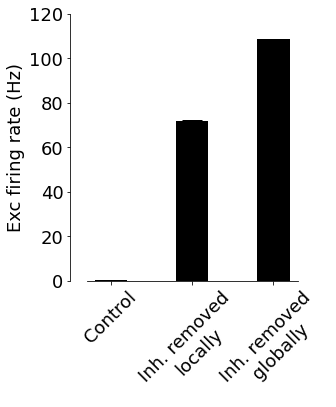

In [23]:
fig, ax = plt.subplots(figsize=(5, 6))
for di in range(3):
    ax.bar(di, np.mean(all_spont_E[di]), facecolor='black', width=0.4)
    ax.errorbar(di, np.mean(all_spont_E[di]), yerr=scipy.stats.sem(all_spont_E[di]), c='black', capsize=10)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Detach left and bottom spines
# ax.spines['left'].set_linestyle('--')
# ax.spines['bottom'].set_linestyle('--')

plt.gca().spines['left'].set_position(('data', -0.5))
plt.gca().spines['bottom'].set_position(('data', -0.05))

plt.subplots_adjust(left=0.25,bottom=0.25)

ax. set_xlim(-.3,2.3)
ax.set_ylim(0,120)

ax.set_ylabel('Exc firing rate (Hz)')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Control', 'Inh. removed\nlocally', 'Inh. removed\nglobally'], rotation=45)

# plt.show()
plt.tight_layout()
plt.savefig('response_figs/RespFig3a.svg')

## Response Fig 3B

In [9]:
## GLOBAL INHIBITION
simname = 'dl_1.0'
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
ignor=0

nsims=0

contrast_responses = []

binlen = 200
delay = 200
stimargs = {'binlen': binlen, 'delay': delay, 'n_repeats': 6}

for seed in range(1,25):

    folder = 'data/%s/results_%s/'%(simname, seed)
    
    print(folder)
    not_all_found=False
    for stim_type in ['PV','SOM']:
        ctrl_curve = []
        for ci, cont in enumerate(contrasts):
            print('contrast', cont)

            try:
                with open(folder + '%s_%s_positions.pickle'%(stim_type,cont), 'rb') as f:
                    all_positions = pickle.load(f)
                with open(folder + '%s_%s_spikes.pickle'%(stim_type,cont), 'rb') as f:
                    all_spikes = pickle.load(f)

            except (EOFError, FileNotFoundError) as te:
                print (te)
                not_all_found = True
                break

            ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans_v2(all_spikes[:8000], all_positions[:8000], **stimargs)

            ctrl_curve.append(ctrlpv_E_mean)
        
        if len(ctrl_curve)!= len(contrasts):
            continue

        contrast_responses.append(ctrl_curve)
        nsims += 1
        if nsims >=20: ## Collect up to 20 sims
            break
    if nsims >=20: ## Collect up to 20 sims
        break

global_responses = np.array(contrast_responses)

## LOCAL INHIBITION
simname = 'dl_0.3'
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
ignor=0
binlen = 100

nsims=0

contrast_responses = []
binlen = 200
delay = 200
stimargs = {'binlen': binlen, 'delay': delay, 'n_repeats': 6}

for seed in range(1,25):
    
    folder = 'data/%s/results_%s/'%(simname, seed)
    
    print(folder)
    not_all_found=False
    for stim_type in ['PV','SOM']:
        ctrl_curve = []
        for ci, cont in enumerate(contrasts):
            print('contrast', cont)

            try:
                with open(folder + '%s_%s_positions.pickle'%(stim_type,cont), 'rb') as f:
                    all_positions = pickle.load(f)
                with open(folder + '%s_%s_spikes.pickle'%(stim_type,cont), 'rb') as f:
                    all_spikes = pickle.load(f)

            except (EOFError, FileNotFoundError) as te:
                print (te)
                not_all_found = True
                break

            ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans_v2(all_spikes[:8000], all_positions[:8000], **stimargs)

            ctrl_curve.append(ctrlpv_E_mean)
        
        if len(ctrl_curve)!= len(contrasts):
            continue

        contrast_responses.append(ctrl_curve)
        nsims += 1
        if nsims >=20: ## Collect up to 20 sims
            break
    if nsims >=20: ## Collect up to 20 sims
        break
        
local_responses = np.array(contrast_responses)


data/dl_1.0/results_1/
contrast 0.02
contrast 0.05
contrast 0.1
contrast 0.18
contrast 0.33
contrast 0.02
contrast 0.05
contrast 0.1
contrast 0.18
contrast 0.33
data/dl_1.0/results_2/
contrast 0.02
contrast 0.05
contrast 0.1
contrast 0.18
contrast 0.33
contrast 0.02
contrast 0.05
contrast 0.1
[Errno 2] No such file or directory: 'data/dl_1.0/results_2/SOM_0.1_positions.pickle'
data/dl_1.0/results_3/
contrast 0.02
contrast 0.05
contrast 0.1
contrast 0.18
contrast 0.33
contrast 0.02
contrast 0.05
[Errno 2] No such file or directory: 'data/dl_1.0/results_3/SOM_0.05_positions.pickle'
data/dl_1.0/results_4/
contrast 0.02
contrast 0.05
contrast 0.1
contrast 0.18
contrast 0.33
contrast 0.02
contrast 0.05
[Errno 2] No such file or directory: 'data/dl_1.0/results_4/SOM_0.05_positions.pickle'
data/dl_1.0/results_5/
contrast 0.02
contrast 0.05
contrast 0.1
contrast 0.18
contrast 0.33
contrast 0.02
[Errno 2] No such file or directory: 'data/dl_1.0/results_5/SOM_0.02_positions.pickle'
data/dl_1.0/r

In [141]:
local_average = np.mean(local_responses, axis=0)
global_average = np.mean(global_responses, axis=0)

params, cov = fit_naka_rushton(contrasts, local_average)
local_m, local_C, local_n, local_k = params

params, cov = fit_naka_rushton(contrasts, global_average)
global_m, global_C, global_n, global_k = params

data = {'inh_removed_locally': local_responses, 'inh_removed_globally': global_responses,
       'inh_removed_locally_average': local_average, 'inh_removed_globally_average': global_average,
       'inh_removed_locally_b': local_m, 'inh_removed_locally_Rm': local_C,
        'inh_removed_locally_n': local_n, 'inh_removed_locally_x50': local_k,
        'inh_removed_globally_b': global_m, 'inh_removed_globally_Rm': global_C,
        'inh_removed_globally_n': global_n, 'inh_removed_globally_x50': global_k
       }

scipy.io.savemat(f'{REVISION_DATA_DIR}/RespFig3B.mat', data)

In Code parameter names are : 
$$m + C\frac{(x^n)}{(x^n + k^n)}$$

In Paper parameter names are : 
$$b + Rm\frac{(x^n)}{(x^n + x_{50}^n)}$$

In [6]:
data = scipy.io.loadmat(f'{REVISION_DATA_DIR}/RespFig3B.mat')
local_m = float(data['inh_removed_locally_b'])
local_C = float(data['inh_removed_locally_Rm'])
local_n = float(data['inh_removed_locally_n'])
local_k = float(data['inh_removed_locally_x50'])
local_average = (data['inh_removed_locally_average'])
local_responses = data['inh_removed_locally']

global_m = float(data['inh_removed_globally_b'])
global_C = float(data['inh_removed_globally_Rm'])
global_n = float(data['inh_removed_globally_n'])
global_k = float(data['inh_removed_globally_x50'])
global_average = data['inh_removed_globally_average']
global_responses = data['inh_removed_globally']

contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])

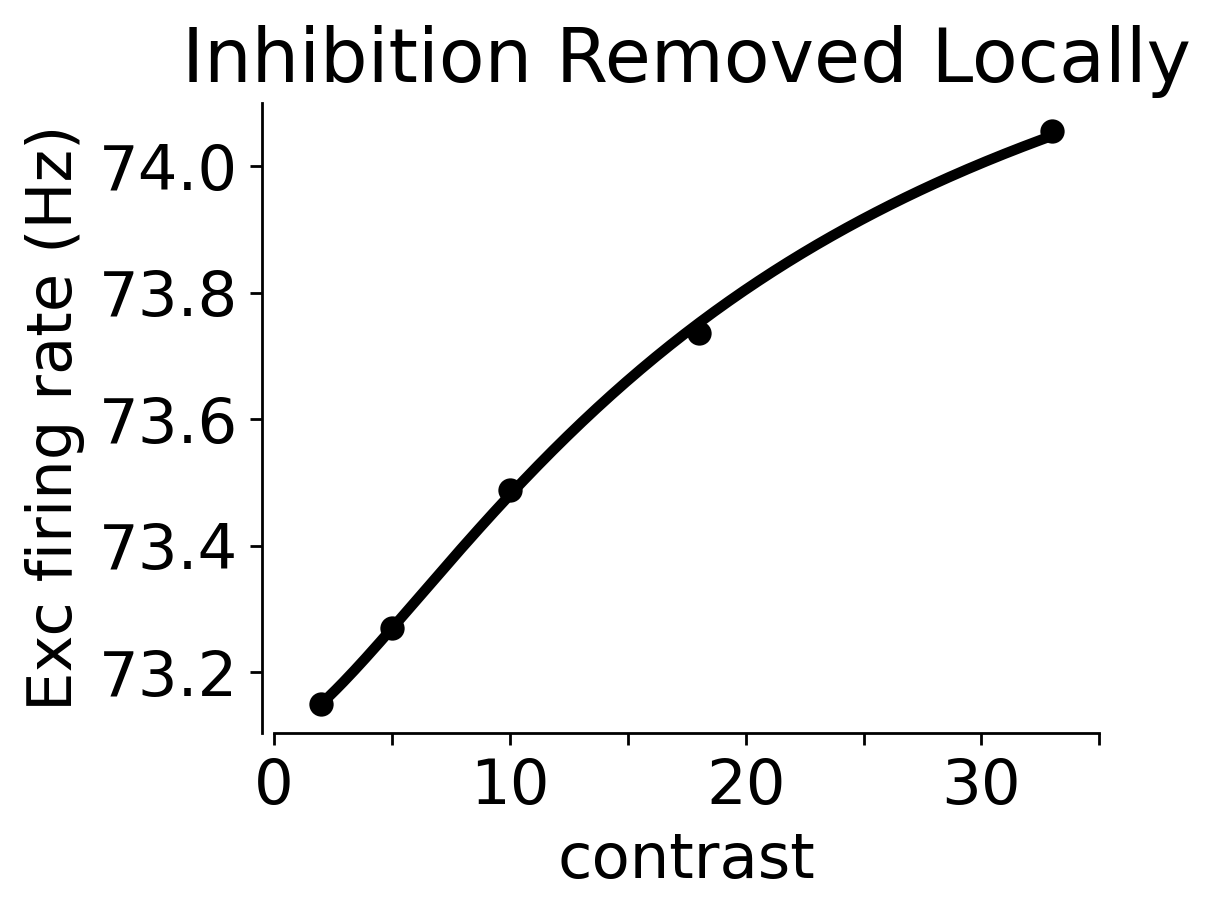

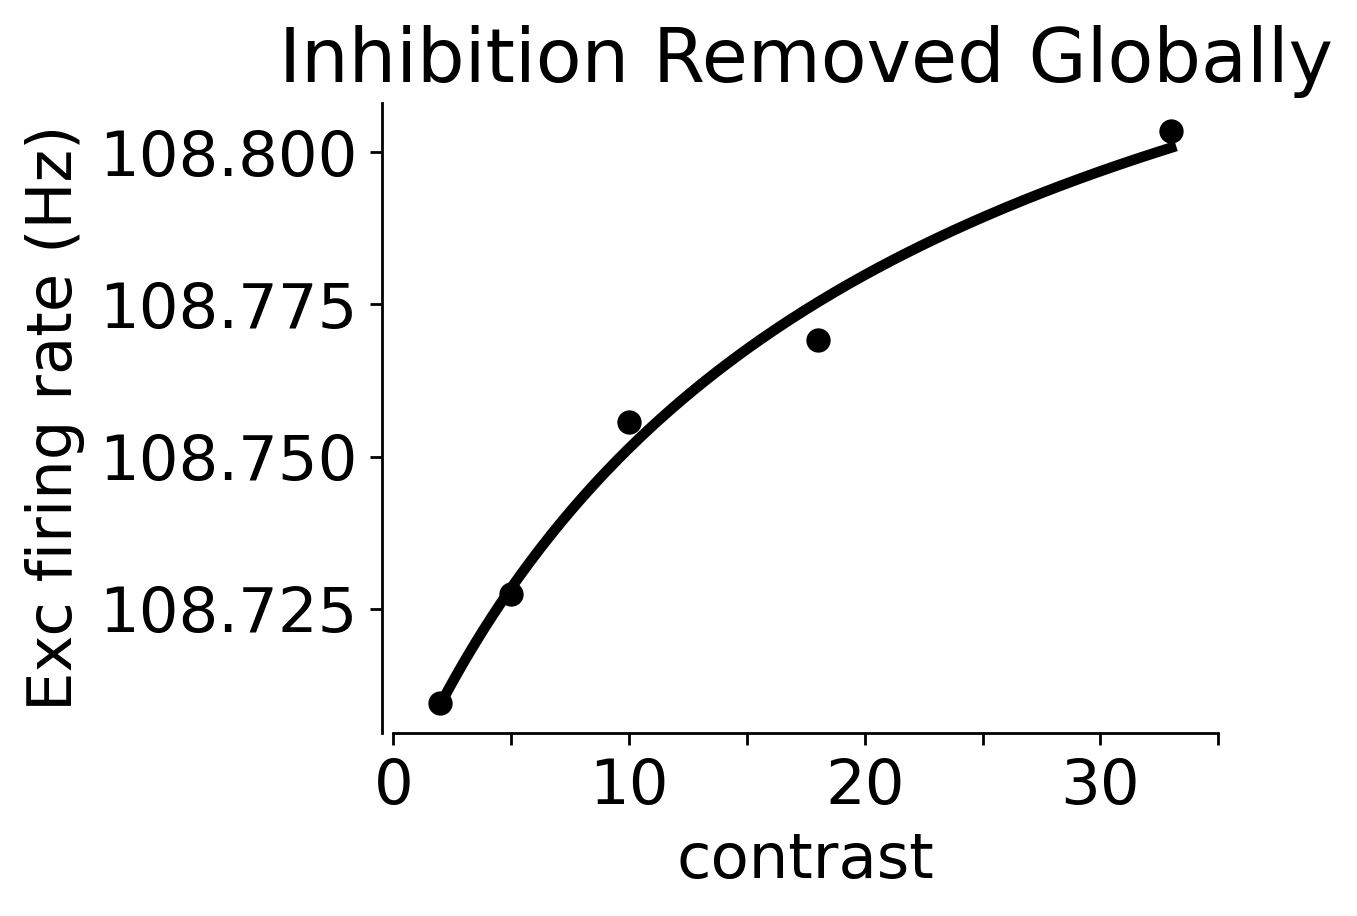

In [12]:

import matplotlib.ticker as mticker
cvals = np.linspace(0.02,0.33,200)
local_yvals = naka_rushton(cvals, local_m, local_C, local_n, local_k)

fig, ax = plt.subplots(figsize=(6, 4), dpi=250)
ax.scatter(contrasts*100, local_average, c='black')
ax.plot(cvals*100, local_yvals, c='black', lw=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('data', -0.5))
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.8)
ax.set_xlabel('contrast')

ax.set_ylabel('Exc firing rate (Hz)')
ax.set_xticks([0,5,10,15,20,25,30,35])
ax.set_xticklabels([0,'',10,'',20,'',30,''])
plt.title('Inhibition Removed Locally')
plt.savefig('response_figs/RespFig3blocal.svg')

cvals = np.linspace(0.02,0.33,200)
global_yvals = naka_rushton(cvals, global_m, global_C, global_n, global_k)

fig, ax = plt.subplots(figsize=(6, 4), dpi=250)
ax.scatter(contrasts*100, global_average, c='black')
ax.plot(cvals*100, global_yvals, c='black', lw=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('data', -0.5))

plt.subplots_adjust(left=0.25, bottom=0.25, right=0.8)
ax.set_xlabel('contrast')

ax.set_ylabel('Exc firing rate (Hz)')
ax.set_xticks([0,5,10,15,20,25,30,35])
ax.set_xticklabels([0,'',10,'',20,'',30,''])
plt.title('Inhibition Removed Globally')

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

# plt.show()
plt.savefig('response_figs/RespFig3bglobal.svg')

## Response Fig 3C

In [8]:
def bin_fr(spikes, tmin, tmax, dt):
    alls = [t for event in spikes for t in event]
    hist, bins = np.histogram(alls, bins=np.arange(tmin, tmax + dt, dt))
    rates = hist / dt / len(spikes) *1000
    return rates, bins[:-1]

def get_averages(spikes, tlen = 200, delay = 200, simtime = 800, repeats = 2, dt = 5):
    
    ctrl_times = []
    stim_times = []
    for repeat in range(repeats):
        ctrl_times.append(delay + simtime*repeat*2)
        stim_times.append(delay + simtime*(2*repeat+1))
#         print(delay + simtime*repeat*2, delay + simtime*(2*repeat+1))
    hists_ctrl = []
    for tim in ctrl_times:
        hist,bins = bin_fr(spikes, tim, tim+tlen, dt)
        hists_ctrl.append(hist)
    hists_stim = []
    for tim in stim_times:
        hist,bins = bin_fr(spikes, tim, tim+tlen, dt)
        hists_stim.append(hist)
        
    return bins, np.mean(hists_ctrl, axis=0), np.mean(hists_stim, axis=0)

In [128]:
# Retrieve data and save as mat file
chr2_list = [ round(0.004*i, 6) for i in range(0,401,2)]
# chr2_list = [0.0]
e_fr, i_fr = [], []
p_fr, s_fr = [], []
x= []
for chr2 in chr2_list:
    simname = 'ps19_%s'%chr2
    seed = 1
    cond = 'BOTH'
    datadir='/storage/home/hcoda1/5/skim3438/p-hchoi387-0/CellTypeCircuit/newCode/data'
    try:
        with open(f'{datadir}/{simname}/results_{seed}/%s_spikes.pickle'%cond,'rb') as f:
            all_spikes = pickle.load(f)
    except FileNotFoundError:
        continue
    x.append(chr2)
    t, ctrl, chr2 = get_averages(all_spikes[0:8000], delay=200, tlen=400, dt=10, repeats=2)
    e_fr.append(np.mean(chr2[:30]))
    t, ctrl, chr2 = get_averages(all_spikes[8000:10000], delay=200, tlen=400, dt=10, repeats=2)
    i_fr.append(np.mean(chr2[:30]))
    t, ctrl, chr2 = get_averages(all_spikes[8000:9000], delay=200, tlen=400, dt=10, repeats=2)
    p_fr.append(np.mean(chr2[:30]))
    t, ctrl, chr2 = get_averages(all_spikes[9000:10000], delay=200, tlen=400, dt=10, repeats=2)
    s_fr.append(np.mean(chr2[:30]))
    
data = {'chr2_strength': x, 'E_firing_rates': e_fr, 'I_firing_rates': i_fr, 'PV_firing_rates': p_fr, 'SST_firing_rates': s_fr}
scipy.io.savemat(f'{REVISION_DATA_DIR}/RespFig3C.mat', data)

In [9]:
## Unpack Data from mat file
data = scipy.io.loadmat(f'{REVISION_DATA_DIR}/RespFig3C.mat')
e_fr = data['E_firing_rates'].flatten()
i_fr = data['I_firing_rates'].flatten()
p_fr = data['PV_firing_rates'].flatten()
s_fr = data['SST_firing_rates'].flatten()
x = data['chr2_strength'].flatten()

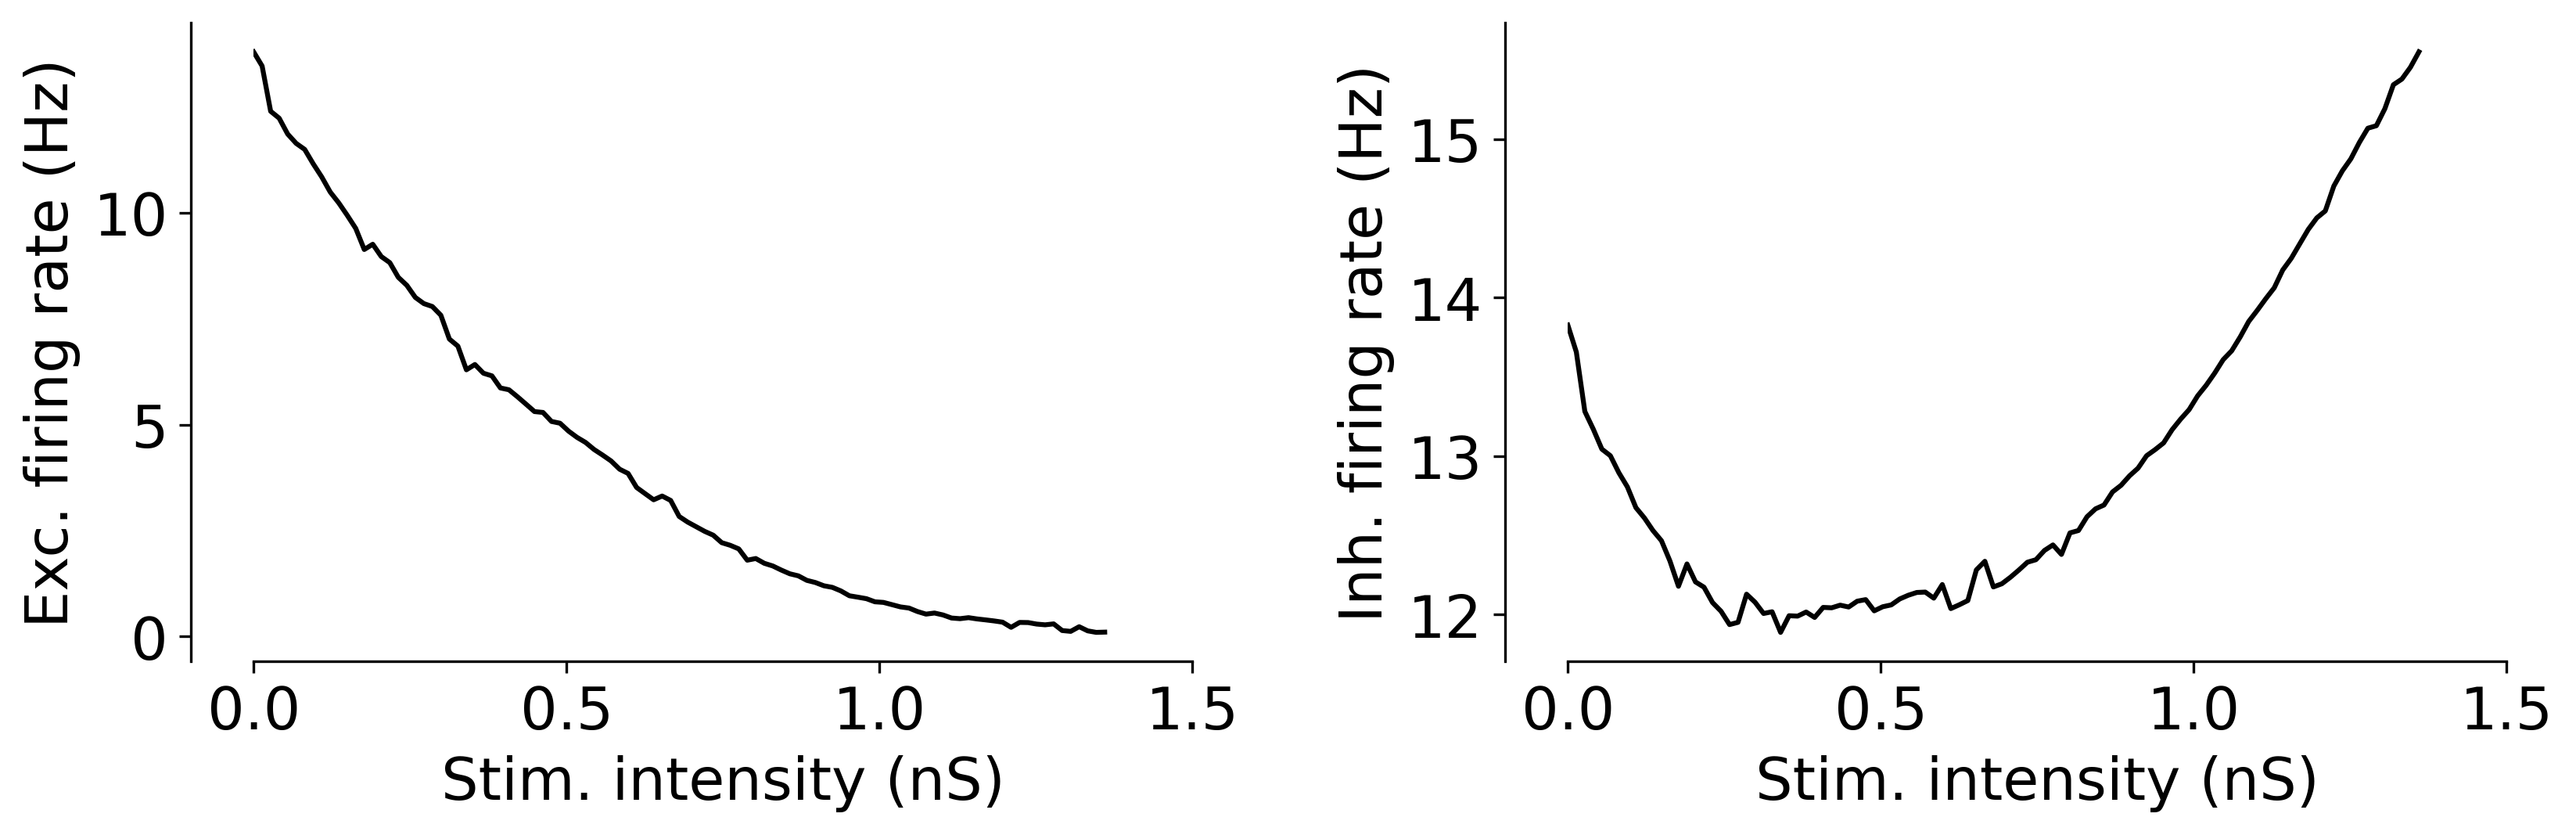

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (16,4), dpi=300)

chr2_str = np.array(x)*1.7
dlen = len(chr2_str)

axes[0].plot(chr2_str[:dlen], e_fr[:dlen], c='black')
axes[1].plot(chr2_str[:dlen], i_fr[:dlen], c='black')
# axes[2].plot(chr2_str[:dlen], p_fr[:dlen], c='black')
# axes[3].plot(chr2_str[:dlen], s_fr[:dlen], c='black')

# axes[0].scatter(chr2_str[:dlen], e_fr[:dlen], c='black')
# axes[1].scatter(chr2_str[:dlen], i_fr[:dlen], c='black')
# axes[2].scatter(chr2_str[:dlen], p_fr[:dlen], c='black')
# axes[3].scatter(chr2_str[:dlen], s_fr[:dlen], c='black')

axes[0].set_ylabel('Exc. firing rate (Hz)')
axes[1].set_ylabel('Inh. firing rate (Hz)')
# axes[2].set_ylabel('PV firing rate (Hz)')
# axes[3].set_ylabel('SST firing rate (Hz)')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('data', -0.1))

for ax in axes:
    ax.set_xlim(0,1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Stim. intensity (nS)')
    
plt.subplots_adjust(left=0.3,bottom=0.2, wspace=0.4)
    
plt.savefig('response_figs/RespFig3c.svg')

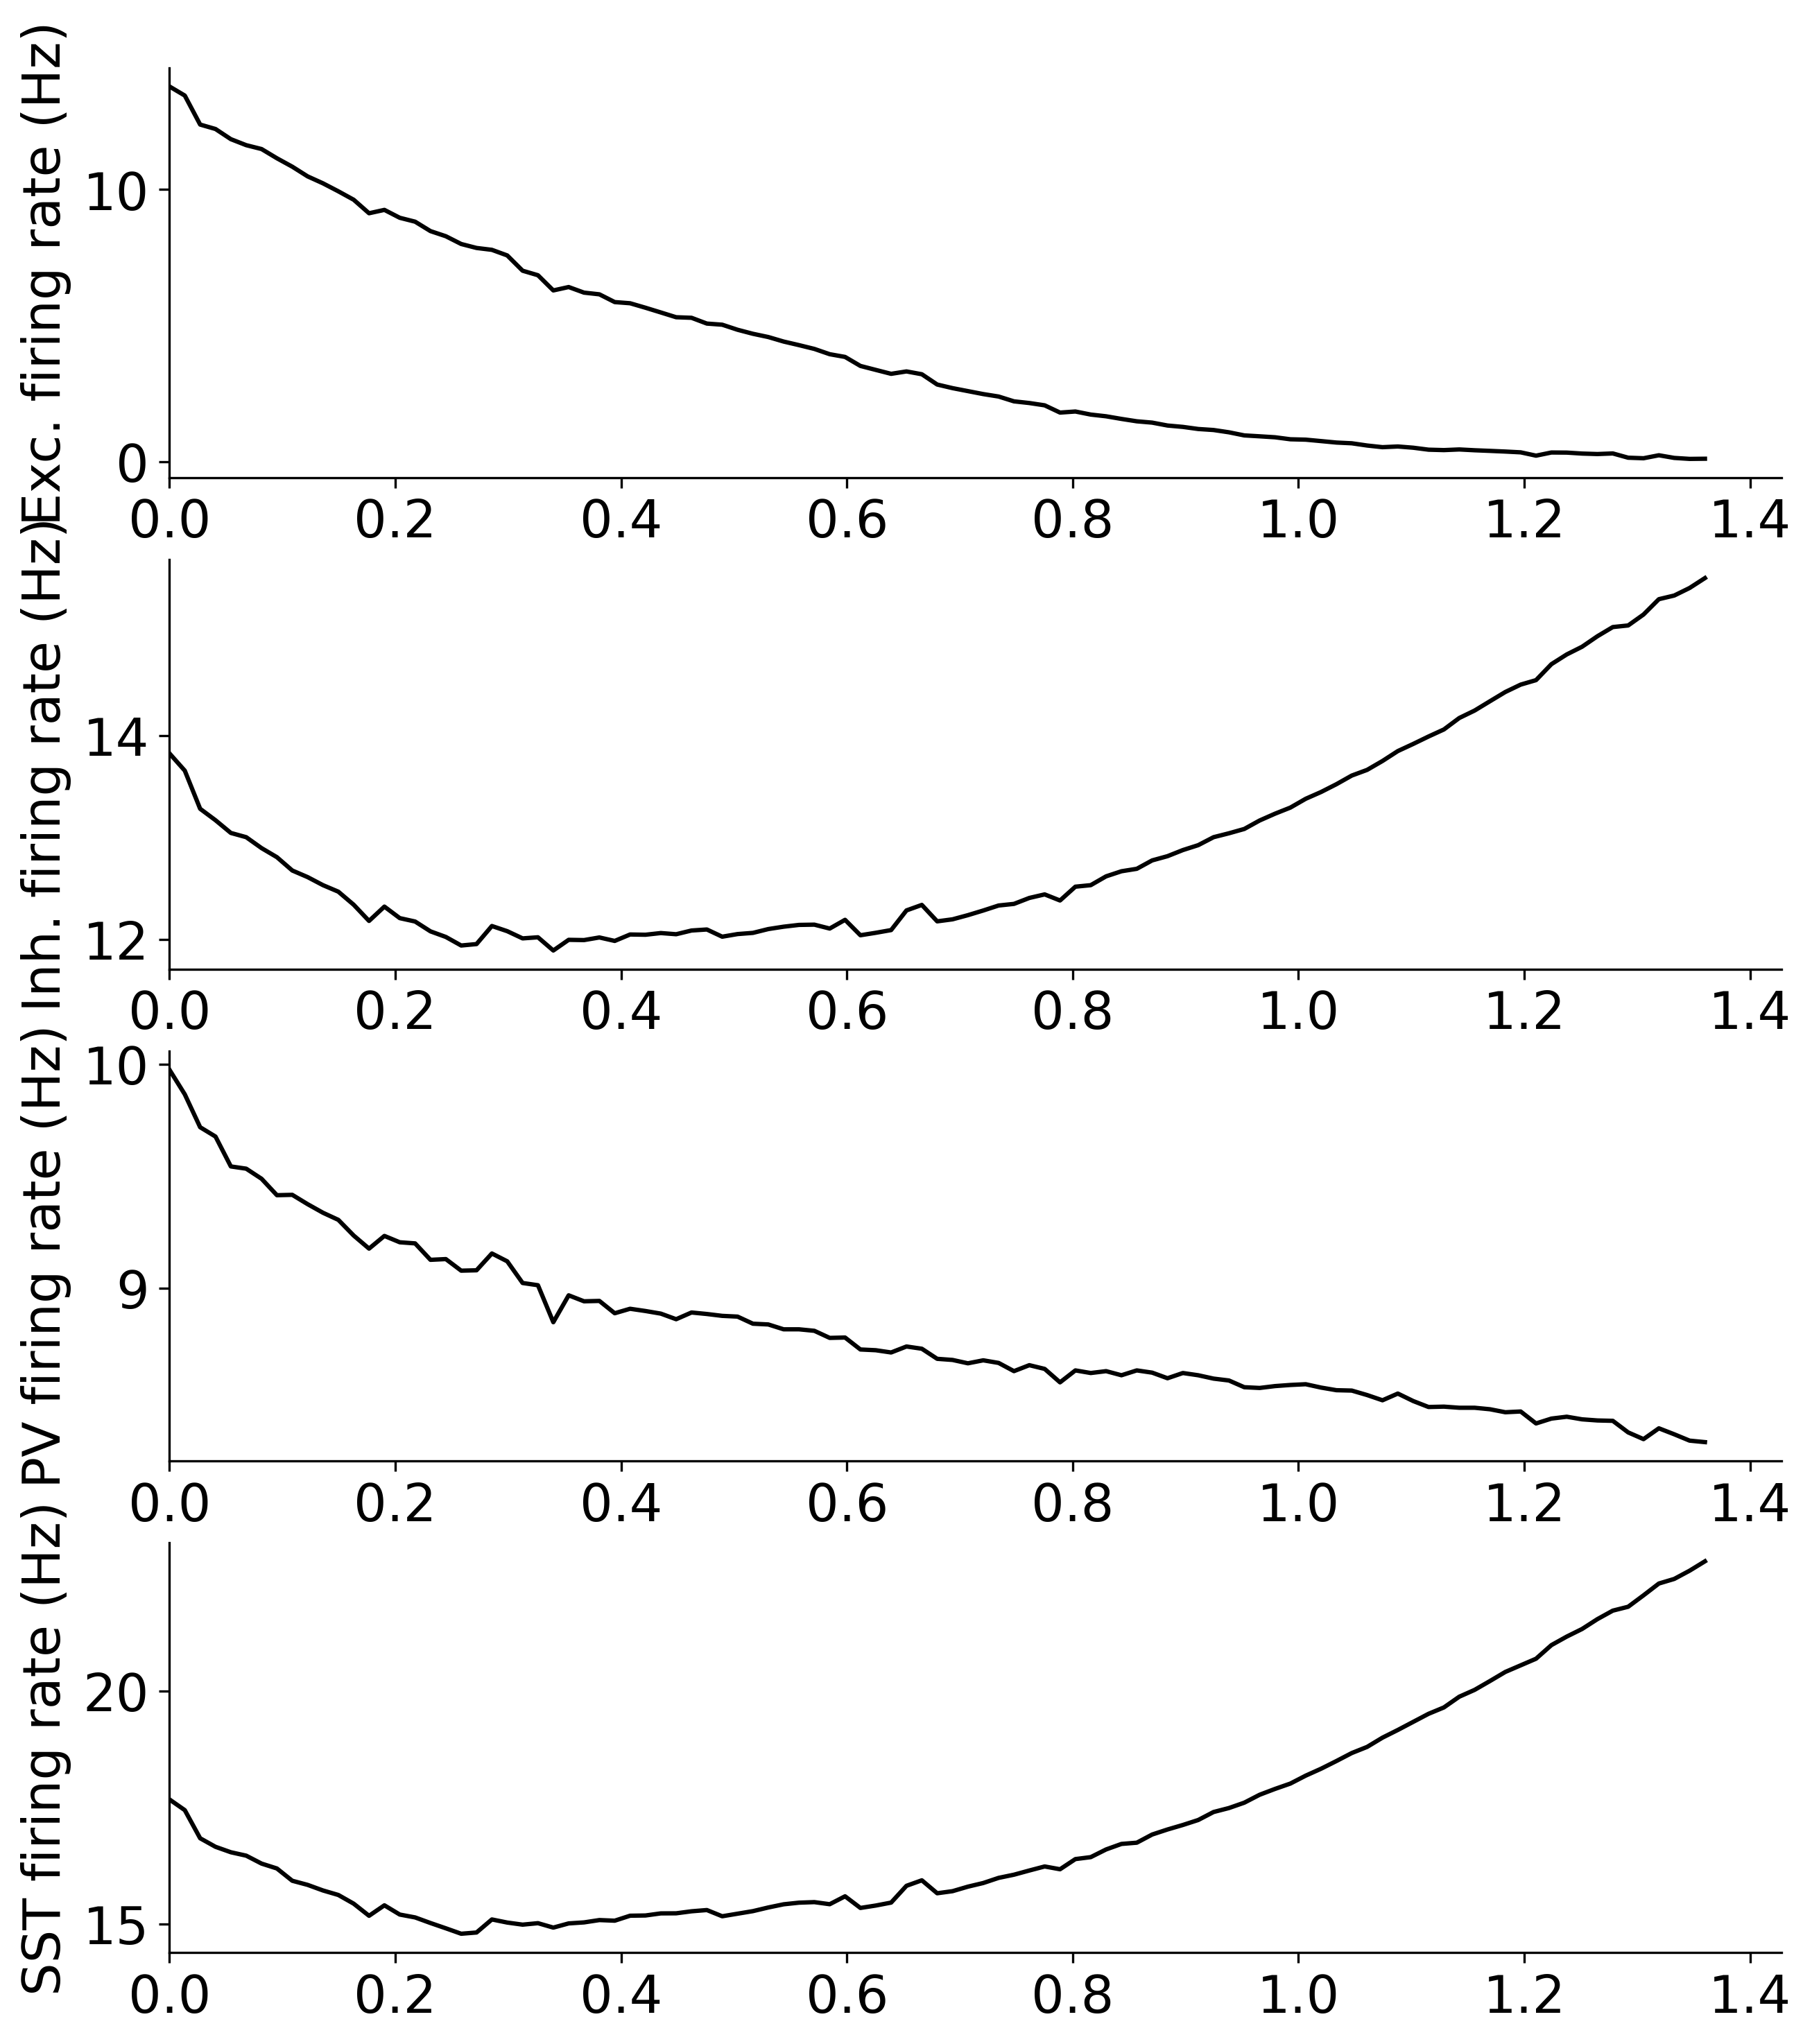

In [31]:
fig, axes = plt.subplots(4, 1, figsize = (10,12), dpi=300)

chr2_str = np.array(x)*1.7
dlen = len(chr2_str)

axes[0].plot(chr2_str[:dlen], e_fr[:dlen], c='black')
axes[1].plot(chr2_str[:dlen], i_fr[:dlen], c='black')
axes[2].plot(chr2_str[:dlen], p_fr[:dlen], c='black')
axes[3].plot(chr2_str[:dlen], s_fr[:dlen], c='black')

# axes[0].scatter(chr2_str[:dlen], e_fr[:dlen], c='black')
# axes[1].scatter(chr2_str[:dlen], i_fr[:dlen], c='black')
# axes[2].scatter(chr2_str[:dlen], p_fr[:dlen], c='black')
# axes[3].scatter(chr2_str[:dlen], s_fr[:dlen], c='black')

axes[0].set_ylabel('Exc. firing rate (Hz)')
axes[1].set_ylabel('Inh. firing rate (Hz)')
axes[2].set_ylabel('PV firing rate (Hz)')
axes[3].set_ylabel('SST firing rate (Hz)')


for ax in axes:
    ax.set_xlim(0,)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)